Data loaded sucessfully

First 5 rows of the dataset:
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  Sale

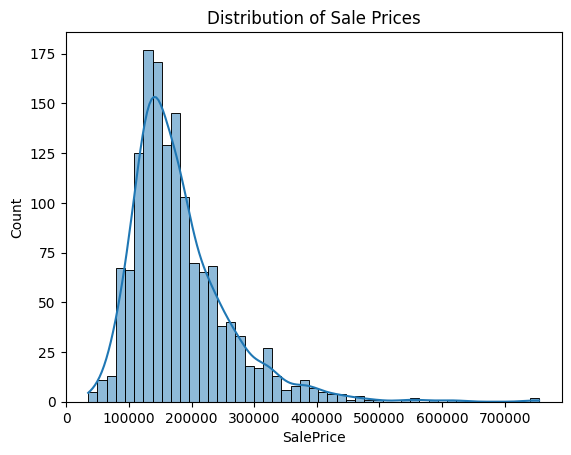

In [49]:
# step 1 : import required libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error , mean_absolute_error
import joblib
try:
    train_df = pd.read_csv('train.csv')
    print("Data loaded sucessfully")

except FileExistsError:
    print("Error: train.csv not found. Make sure the file is in the same directory as your script.")
    exit()



# 3. Initial exploration of the data
print("\nFirst 5 rows of the dataset:")
print(train_df.head())

print("\nInformation about the dataset:")
train_df.info()

print("\nStatistical summary of the numerical features:")
print(train_df.describe())

# Let's also look at the target variable, 'SalePrice'
print("\nDistribution of SalePrice:")
sns.histplot(train_df['SalePrice'], kde=True)
plt.title('Distribution of Sale Prices')
plt.show() # This will open a new window with the plot



In [50]:
print('\n---Handle Missing Data---')

missing_values = train_df.isnull().sum()
missing_percentage = missing_values / len(train_df) * 100
missing_data_summary = pd.DataFrame({
    'Missing Count' : missing_values , 
    'Percentage' : missing_percentage
})

missing_data_summary = missing_data_summary[missing_data_summary['Missing Count'] > 0].sort_values(by='Percentage',
                                                                                                    ascending=False)
print("\nSummary of columns with missing data (before handling):")
print(missing_data_summary)
print(missing_data_summary.index)



---Handle Missing Data---

Summary of columns with missing data (before handling):
              Missing Count  Percentage
PoolQC                 1453   99.520548
MiscFeature            1406   96.301370
Alley                  1369   93.767123
Fence                  1179   80.753425
MasVnrType              872   59.726027
FireplaceQu             690   47.260274
LotFrontage             259   17.739726
GarageType               81    5.547945
GarageYrBlt              81    5.547945
GarageFinish             81    5.547945
GarageQual               81    5.547945
GarageCond               81    5.547945
BsmtExposure             38    2.602740
BsmtFinType2             38    2.602740
BsmtQual                 37    2.534247
BsmtCond                 37    2.534247
BsmtFinType1             37    2.534247
MasVnrArea                8    0.547945
Electrical                1    0.068493
Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu',
       'LotFrontage', 'GarageType', '

In [51]:
print("\nApplying strategies to handle missing data...")

cols_to_drop = ['PoolQC' , 'MiscFeature' , 'Alley' , 'Fence']
train_df.drop(columns=cols_to_drop , inplace=True)
print(f"->Drop columns :{cols_to_drop}")


Applying strategies to handle missing data...
->Drop columns :['PoolQC', 'MiscFeature', 'Alley', 'Fence']


In [52]:

# --- 2. ملء القيم الفئوية (Categorical Imputation) ---
# بالنسبة لهذه الأعمدة، القيمة المفقودة (NaN) تعني "لا يوجد" ميزة معينة.
categorical_cols_fill_none = [
    'FireplaceQu', 'MasVnrType', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'
]
for col in categorical_cols_fill_none:
    train_df[col].fillna('None', inplace=True)
print(f"-> Filled categorical columns with 'None': {len(categorical_cols_fill_none)} columns")

# Electrical: لديه قيمة مفقودة واحدة فقط، نملؤها بالقيمة الأكثر تكرارًا.
electrical_mode = train_df['Electrical'].mode()[0]
train_df['Electrical'].fillna(electrical_mode, inplace=True)
print(f"-> Filled 'Electrical' with mode value: '{electrical_mode}'")


# --- 3. ملء القيم الرقمية (Numerical Imputation) ---
# LotFrontage: نستخدم الوسيط لأنه أكثر مقاومة للقيم المتطرفة.
lotfrontage_median = train_df['LotFrontage'].median()
train_df['LotFrontage'].fillna(lotfrontage_median, inplace=True)
print(f"-> Filled 'LotFrontage' with median value: {lotfrontage_median}")

# الأعمدة الرقمية التي تعني فيها القيمة المفقودة "صفر".
numerical_cols_fill_zero = ['MasVnrArea', 'GarageYrBlt', 'GarageArea', 'GarageCars']
for col in numerical_cols_fill_zero:
    train_df[col].fillna(0, inplace=True)
print(f"-> Filled numerical columns with 0: {numerical_cols_fill_zero}")


# --- 4. التحقق النهائي ---
remaining_missing = train_df.isnull().sum().max()
if remaining_missing == 0:
    print("\n✅ Success! All missing values have been handled.")
else:
    print(f"\n⚠️ Warning! There are still {train_df.isnull().sum().sum()} missing values remaining.")
    # طباعة الأعمدة المتبقية إذا وجدت
    print(train_df.isnull().sum()[train_df.isnull().sum() > 0])

# عرض معلومات DataFrame للتأكد من أن جميع الأعمدة تحتوي على 1460 قيمة غير فارغة
print("\nDataFrame info after handling missing values:")
train_df.info()


-> Filled categorical columns with 'None': 11 columns
-> Filled 'Electrical' with mode value: 'SBrkr'
-> Filled 'LotFrontage' with median value: 69.0
-> Filled numerical columns with 0: ['MasVnrArea', 'GarageYrBlt', 'GarageArea', 'GarageCars']

✅ Success! All missing values have been handled.

DataFrame info after handling missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 77 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460

C:\Users\elkholey\AppData\Local\Temp\ipykernel_25864\120443139.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[col].fillna('None', inplace=True)
C:\Users\elkholey\AppData\Local\Temp\ipykernel_25864\120443139.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exam

In [53]:
# (الكود السابق لمعالجة البيانات المفقودة يجب أن يكون هنا)

# =================================================================
# Step 4: Feature Engineering & Data Splitting
# =================================================================
print("\n--- Step 4: Feature Engineering & Data Splitting ---")

# --- 4.1: تحويل الأعمدة الفئوية إلى أرقام (One-Hot Encoding) ---
print("\nIdentifying categorical columns for encoding...")

# تحديد الأعمدة التي نوعها 'object' لتحويلها
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()
print(f"Found {len(categorical_cols)} categorical features to encode: {categorical_cols}")

# استخدام دالة get_dummies لتحويل الأعمدة الفئوية
# drop_first=True مهم لتجنب مشكلة الارتباط المتعدد بين المتغيرات الوهمية
df_processed = pd.get_dummies(train_df, columns=categorical_cols, drop_first=True)

print(f"Original shape: {train_df.shape}")
print(f"Shape after One-Hot Encoding: {df_processed.shape}")


# --- 4.2: فصل الميزات (X) عن المتغير الهدف (y) ---
print("\nSeparating data into features (X) and target (y)...")

# المتغير الهدف الذي نريد التنبؤ به هو 'SalePrice'
y = df_processed['SalePrice']

# الميزات (X) هي كل الأعمدة ما عدا 'SalePrice' و 'Id' (لأن Id مجرد رقم تسلسلي)
X = df_processed.drop(columns=['SalePrice', 'Id'])

print(f"Features matrix shape (X): {X.shape}")
print(f"Target vector shape (y): {y.shape}")


# --- 4.3: تقسيم البيانات إلى مجموعات تدريب واختبار ---
from sklearn.model_selection import train_test_split

print("\nSplitting data into training and validation sets (80/20 split)...")

# test_size=0.2 يعني أن 20% من البيانات ستكون للاختبار (validation)
# random_state=42 يضمن أن التقسيم يكون متماثلاً في كل مرة نشغل فيها الكود
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training features shape: {X_train.shape}")
print(f"Validation features shape: {X_val.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Validation target shape: {y_val.shape}")

print("\n✅ Data is now fully preprocessed and ready for model training.")



--- Step 4: Feature Engineering & Data Splitting ---

Identifying categorical columns for encoding...
Found 39 categorical features to encode: ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']
Original shape: (1460, 77)
Shape after One-Hot Encoding: (1460, 248)

Separating data into features (X) and target (y)...
Features matrix shape (X): (1460, 246)
Target vector shape (y): (1460,)

Splitting data into training and validation sets (80/20 split)...
Training features shape: (1168, 246)
Validation features s

In [54]:
print("\n--- step 5: Training and evaluating the Random Forest Regressor Model ---")

RF_model = RandomForestRegressor (n_estimators= 100 , random_state= 42 , n_jobs= -1)

RF_model.fit(X_train , y_train)
print("Model Train Completed.")

print('Making Predicting on Validation set...')
y_pred = RF_model.predict(X_val)
print('Evaluating model perforamance...')

MAE = mean_absolute_error (y_val , y_pred)
MSE = mean_squared_error(y_val , y_pred)
RMSE = np.sqrt (MSE)

print(f"Mean Absolute Error (MAE): ${MAE:,.2f}")
print(f"Mean Squared Error (MSE): {MSE:,.2f}")
print(f"Root Mean Squared Error (RMSE): ${RMSE:,.2f}")



--- step 5: Training and evaluating the Random Forest Regressor Model ---
Model Train Completed.
Making Predicting on Validation set...
Evaluating model perforamance...
Mean Absolute Error (MAE): $17,526.23
Mean Squared Error (MSE): 820,358,846.77
Root Mean Squared Error (RMSE): $28,641.91


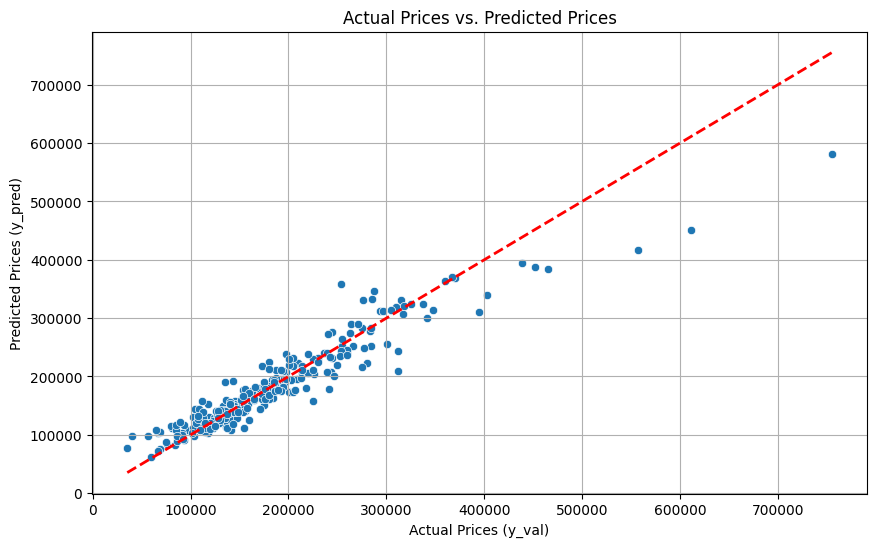

In [55]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_val, y=y_pred)
plt.xlabel("Actual Prices (y_val)")
plt.ylabel("Predicted Prices (y_pred)")
plt.title("Actual Prices vs. Predicted Prices")
# إضافة خط مثالي (y=x) للمقارنة
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--', lw=2)
plt.grid(True)
plt.show()

In [56]:
print('--- Saving the training Model ---')
model_FileName = 'random_forest_house_pricer.joblib'

print(f'Saving model to {model_FileName} ...')
joblib.dump(RF_model , model_FileName)
print('Model Saved Successfully . ')# (الكود السابق لحفظ النموذج يجب أن يكون هنا)

# =================================================================
# Step 7: Export Artifacts for the Web Application
# =================================================================
print("\n--- Step 7: Exporting artifacts for the web application ---")

import json

# --- 7.1: حفظ قائمة الأعمدة النهائية للنموذج ---
# X هو الـ DataFrame الذي يحتوي على جميع الميزات بعد الترميز وقبل التقسيم
model_columns = X.columns
columns_filename = 'model_columns.joblib'
joblib.dump(model_columns, columns_filename)
print(f"✅ Model columns saved to '{columns_filename}'.")


# --- 7.2: حفظ القيم الفريدة للأعمدة الفئوية الرئيسية ---
# سنحفظ هذه القيم في ملف JSON لسهولة قراءتها في تطبيق Flask
categorical_values = {}

# اخترنا 'Neighborhood' كمثال رئيسي لواجهة المستخدم
# train_df هو الـ DataFrame الأصلي قبل عملية One-Hot Encoding
# .dropna() لإزالة أي قيم فارغة و .unique() للحصول على القيم الفريدة
# .tolist() لتحويلها إلى قائمة بايثون عادية
categorical_values['Neighborhood'] = train_df['Neighborhood'].dropna().unique().tolist()
# يمكنك إضافة أعمدة أخرى هنا إذا أردت استخدامها في الواجهة
# مثال: categorical_values['SaleCondition'] = train_df['SaleCondition'].dropna().unique().tolist()

# اسم الملف الذي سيحتوي على هذه القوائم
categorical_values_filename = 'categorical_values.json'
with open(categorical_values_filename, 'w') as f:
    json.dump(categorical_values, f)

print(f"✅ Categorical values (like neighborhoods) saved to '{categorical_values_filename}'.")

print("\nAll necessary artifacts for the web app have been created.")



--- Saving the training Model ---
Saving model to random_forest_house_pricer.joblib ...
Model Saved Successfully . 

--- Step 7: Exporting artifacts for the web application ---
✅ Model columns saved to 'model_columns.joblib'.
✅ Categorical values (like neighborhoods) saved to 'categorical_values.json'.

All necessary artifacts for the web app have been created.


In [57]:
print('...Loading model back to verify...')
try : 
    loaded_model = joblib.load(model_FileName)
    print('Model Loaded Successfully.')
    sample_prediction = loaded_model.predict(X_val.head(1))
    print(f"Prediction on a sample data point using loaded model: ${sample_prediction[0]:,.2f}")
    print("✅ Verification successful. The loaded model is working correctly.")

except Exception as e:
    print(f"⚠️ Error during model verification: {e}")

...Loading model back to verify...
Model Loaded Successfully.
Prediction on a sample data point using loaded model: $141,010.75
✅ Verification successful. The loaded model is working correctly.
